In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/common-test/dataset/val/no/422.npy
/kaggle/input/common-test/dataset/val/no/331.npy
/kaggle/input/common-test/dataset/val/no/2434.npy
/kaggle/input/common-test/dataset/val/no/280.npy
/kaggle/input/common-test/dataset/val/no/970.npy
/kaggle/input/common-test/dataset/val/no/2467.npy
/kaggle/input/common-test/dataset/val/no/2424.npy
/kaggle/input/common-test/dataset/val/no/745.npy
/kaggle/input/common-test/dataset/val/no/100.npy
/kaggle/input/common-test/dataset/val/no/1200.npy
/kaggle/input/common-test/dataset/val/no/1170.npy
/kaggle/input/common-test/dataset/val/no/1876.npy
/kaggle/input/common-test/dataset/val/no/719.npy
/kaggle/input/common-test/dataset/val/no/1041.npy
/kaggle/input/common-test/dataset/val/no/193.npy
/kaggle/input/common-test/dataset/val/no/1191.npy
/kaggle/input/common-test/dataset/val/no/461.npy
/kaggle/input/common-test/dataset/val/no/2196.npy
/kaggle/input/common-test/dataset/val/no/63.npy
/kaggle/input/common-test/dataset/val/no/1364.npy
/kaggle/inp

In [2]:
!pip install e2cnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 10.0 MB/s eta 0:00:00


In [3]:
models_dir = '/kaggle/working/models'

if not os.path.exists(models_dir):
    os.mkdir(models_dir)
    print("Directory created successfully")
else:
    print("Directory exists")

Directory created successfully


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import transforms
from e2cnn import gspaces, nn as e2nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
base_dir = "/kaggle/input/common-test/"
train_dataset_path = os.path.join(base_dir, "dataset", "train")
val_dataset_path = os.path.join(base_dir, "dataset", "val")

train_no_path = os.path.join(train_dataset_path, "no")
train_sphere_path = os.path.join(train_dataset_path, "sphere")
train_vort_path = os.path.join(train_dataset_path, "vort")

val_no_path = os.path.join(val_dataset_path, "no")
val_sphere_path = os.path.join(val_dataset_path, "sphere")
val_vort_path = os.path.join(val_dataset_path, "vort")

train_df = pd.DataFrame(columns=['path', 'label'])
val_df = pd.DataFrame(columns=['path', 'label'])

label_map = {'no': 0, 'sphere': 1, 'vort': 2}
val_label_map = {0: 'no', 1: 'sphere', 2: 'vort'}

# For training data
for label, path in [(label, path) for label, path in zip(label_map.keys(), [train_no_path, train_sphere_path, train_vort_path])]:
    entries = [os.path.join(path, j) for j in os.listdir(path)]
    temp_df = pd.DataFrame({'path': entries, 'label': label})
    train_df = pd.concat([train_df, temp_df], ignore_index=True)

# For validation data
for label, path in [(label, path) for label, path in zip(label_map.keys(), [val_no_path, val_sphere_path, val_vort_path])]:
    entries = [os.path.join(path, j) for j in os.listdir(path)]
    temp_df = pd.DataFrame({'path': entries, 'label': label})
    val_df = pd.concat([val_df, temp_df], ignore_index=True)


In [6]:
train = train_df['label'].value_counts()
print(f"Training dataset: {train}")

Training dataset: label
no        10000
sphere    10000
vort      10000
Name: count, dtype: int64


In [7]:
val = val_df['label'].value_counts()
print(f"Validationt dataset: {val}")

Training dataset: label
no        2500
sphere    2500
vort      2500
Name: count, dtype: int64


In [8]:
class Dataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir['path'][idx]
        image = np.load(img_path, allow_pickle=True)[0].astype('float32')
        image = 255 * (image / image.max())
        image = Image.fromarray(image.astype('uint8')).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        label = self.img_dir['label'][idx]
        label = label_map[label]
        
        return image, label

In [9]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dataset = Dataset(train_df, train_transforms)
val_dataset = Dataset(val_df,val_transforms)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = 32, num_workers = 4)
val_loader = DataLoader(val_dataset,  shuffle = True, batch_size = 32, num_workers = 2)

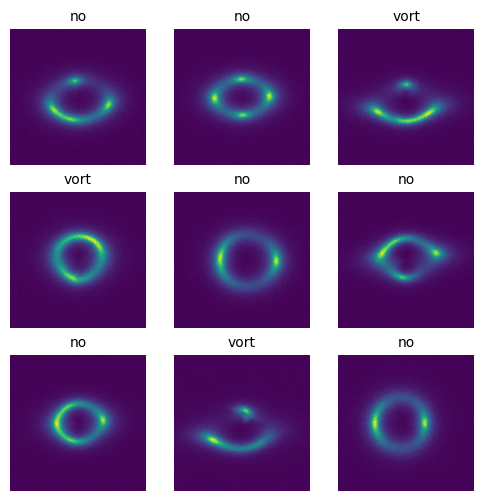

In [10]:
def show_batch(images, labels, class_map):
    fig, ax = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(3):
        for j in range(3):
            image = images[i*4 + j]
            label = labels[i*4 + j].item()
            ax[i][j].imshow(image.permute(1, 2, 0))
            title = [k for k, v in class_map.items() if v == label][0]
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)

    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, label_map)

In [11]:
class C8SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes=3):
        
        super(C8SteerableCNN, self).__init__()
        
        # the model is equivariant under rotations by 45 degrees(2*pi/8), modelled by C8
        self.r2_act = gspaces.Rot2dOnR2(N=8)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = e2nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # Unlike CNNs, we choose the output type of the convolutional layer to be a feature feilds
        # that are equivariant under the group C8 instead of normal feature maps.
        out_type = e2nn.FieldType(self.r2_act, 12*[self.r2_act.regular_repr])
        
        # convolution 1
        # the first covolution layer outputs 12 regular feature fields of C8 as denoted by the out_type
        self.block1 = e2nn.SequentialModule(
            e2nn.MaskModule(in_type, 150, margin=1),
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type   
        
        # convolution 2
        # the second covolution layer outputs 24 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block2 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )

        # pointwise average pooling is used instead of max pooling or average pooling
        # to preserve the rotational symmetry of the feature fields
        self.pool1 = e2nn.SequentialModule(
            e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        in_type = self.block2.out_type

        # convolution 3
        # the third covolution layer outputs 24 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block3 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        
        in_type = self.block3.out_type

        # convolution 4
        # the fourth covolution layer outputs 48 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block4 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = e2nn.SequentialModule(
            e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        in_type = self.block4.out_type

        # convolution 5
        # the fifth covolution layer outputs 48 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block5 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        
        in_type = self.block5.out_type

        # convolution 6
        # the sixth covolution layer outputs 32 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr])
        self.block6 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )

        self.pool3 = e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        # group pooling provides a way to aggregate information from all the feature fields,
        # while preserving the rotational symmetry of the feature fields
        self.gpool = e2nn.GroupPooling(out_type)
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(12800, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):

        x = e2nn.GeometricTensor(input, self.input_type)
        x = self.block1(x)
        x = self.block2(x)

        x = self.pool1(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.pool2(x)
        x = self.block5(x)
        x = self.block6(x)

        x = self.pool3(x)
        x = self.gpool(x)

        x = x.tensor
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

In [12]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, valloader):

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []
        
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0
        
        print(f"Epoch: {i + 1}")
        
        for images, targets in tqdm(trainloader, desc= "Train\t"):
            
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        scheduler.step()
        
        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in tqdm(valloader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_val_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            val_acc.append(acc)
            val_losses.append(running_val_loss / len(valloader))

        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), models_dir+'common-test-model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_acc[-1]:.3f}\n")

    return train_losses, train_acc, val_losses, val_acc, best_acc

In [13]:
model = C8SteerableCNN(n_classes=3).to(device)

epochs = 20
lr = 0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [14]:
train_losses, train_acc, val_losses, val_acc, best_acc = train(model, epochs, optimizer, loss_function, scheduler, device, train_loader, val_loader)

Epoch: 1


Test	: 100%|██████████| 235/235 [00:35<00:00,  6.70it/s]


Train Loss: 1.085, Train Acc: 0.381, Val Loss: 1.012, Val Acc: 0.462

Epoch: 2


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.60it/s]


Train Loss: 0.573, Train Acc: 0.744, Val Loss: 0.270, Val Acc: 0.905

Epoch: 3


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.58it/s]


Train Loss: 0.233, Train Acc: 0.916, Val Loss: 0.215, Val Acc: 0.922

Epoch: 4


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.63it/s]


Train Loss: 0.182, Train Acc: 0.935, Val Loss: 0.201, Val Acc: 0.929

Epoch: 5


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.64it/s]


Train Loss: 0.113, Train Acc: 0.962, Val Loss: 0.149, Val Acc: 0.949

Epoch: 6


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.59it/s]


Train Loss: 0.091, Train Acc: 0.969, Val Loss: 0.144, Val Acc: 0.951

Epoch: 7


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.64it/s]


Train Loss: 0.080, Train Acc: 0.973, Val Loss: 0.150, Val Acc: 0.948

Epoch: 8


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.65it/s]


Train Loss: 0.071, Train Acc: 0.975, Val Loss: 0.145, Val Acc: 0.951

Epoch: 9


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.55it/s]


Train Loss: 0.053, Train Acc: 0.983, Val Loss: 0.143, Val Acc: 0.949

Epoch: 10


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.63it/s]


Train Loss: 0.054, Train Acc: 0.983, Val Loss: 0.137, Val Acc: 0.953

Epoch: 11


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.55it/s]


Train Loss: 0.051, Train Acc: 0.984, Val Loss: 0.144, Val Acc: 0.951

Epoch: 12


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.58it/s]


Train Loss: 0.050, Train Acc: 0.983, Val Loss: 0.145, Val Acc: 0.952

Epoch: 13


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.51it/s]


Train Loss: 0.048, Train Acc: 0.984, Val Loss: 0.149, Val Acc: 0.950

Epoch: 14


Test	: 100%|██████████| 235/235 [04:38<00:00,  1.19s/it]


Train Loss: 0.048, Train Acc: 0.985, Val Loss: 0.143, Val Acc: 0.952

Epoch: 15


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.62it/s]


Train Loss: 0.047, Train Acc: 0.985, Val Loss: 0.146, Val Acc: 0.952

Epoch: 16


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.58it/s]


Train Loss: 0.045, Train Acc: 0.986, Val Loss: 0.142, Val Acc: 0.952

Epoch: 17


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.62it/s]


Train Loss: 0.048, Train Acc: 0.984, Val Loss: 0.145, Val Acc: 0.951

Epoch: 18


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.58it/s]


Train Loss: 0.049, Train Acc: 0.984, Val Loss: 0.140, Val Acc: 0.953

Epoch: 19


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.53it/s]


Train Loss: 0.048, Train Acc: 0.984, Val Loss: 0.147, Val Acc: 0.953

Epoch: 20


Test	: 100%|██████████| 235/235 [00:22<00:00, 10.59it/s]


Train Loss: 0.046, Train Acc: 0.986, Val Loss: 0.151, Val Acc: 0.948



In [15]:
model = C8SteerableCNN(n_classes=3).to(device)
model.load_state_dict(torch.load(models_dir+'common-test-model.pth'))

<All keys matched successfully>

In [16]:
y_true = []
y_pred_class = []
y_pred_prob = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        preds = torch.argmax(output, dim=1)
        y_true.extend(targets.cpu().numpy())
        y_pred_class.extend(preds.cpu().numpy())
        y_pred_prob.extend(output.cpu().numpy())

100%|██████████| 235/235 [00:22<00:00, 10.60it/s]


In [17]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, auc

print(classification_report(y_true, y_pred_class, target_names=label_map.keys()))

              precision    recall  f1-score   support

          no       0.94      0.97      0.96      2500
      sphere       0.95      0.92      0.94      2500
        vort       0.96      0.96      0.96      2500

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500



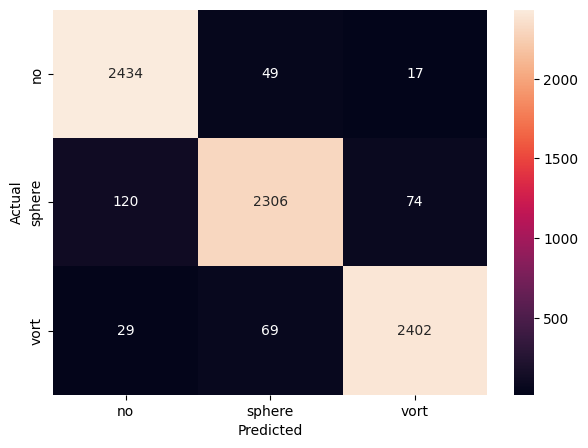

In [18]:
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
def softmax(x):
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=1, keepdims=True)

y_pred_softmax = softmax(np.array(y_pred_prob))

print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred_softmax, multi_class='ovr')}")

ROC-AUC Score: 0.993668


no       ROC-AUC: 0.9945865599999999
sphere   ROC-AUC: 0.98272984
vort     ROC-AUC: 0.9918384000000001


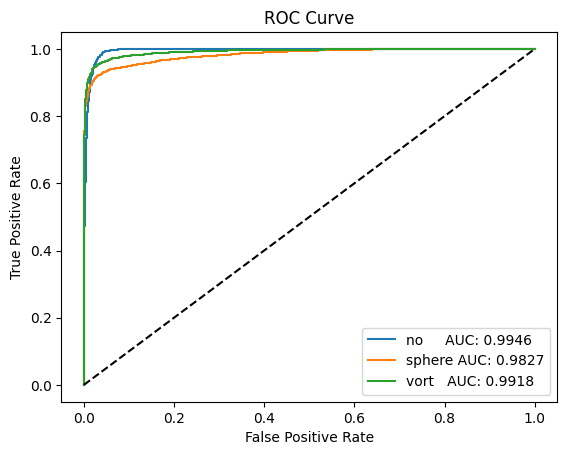

In [20]:
y_true_dummies = pd.get_dummies(y_true).values

auc_scores = {}
for i in range(3):
    fpr_i, tpr_i, thresholds_i = roc_curve(y_true_dummies[:, i], np.array(y_pred_prob)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    print(f"{(val_label_map[i]).ljust(8)} ROC-AUC: {auc_score}")
    auc_scores[val_label_map[i]] = auc_score
    plt.plot(fpr_i, tpr_i, label=f"{(val_label_map[i]).ljust(6)} AUC: {auc_score:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()